Hyper-parameter

In [27]:
import os 
import random
import numpy as np

# VQ_alpha = 10
# init_factor = 1.0
# factor = init_factor
num_repeats = 1000
num_of_episode = 300
x_interval = int(num_of_episode/10)
v_noise = 0.00
sigma = 1.0
mu = -0.1
nB = 20
rbs = 1  # replay buffer size
bs = 1  # batch size

# save_path = f"/storage/xue/repos/Reinforcement_Learning/images/ex6.7/Q_DQ_VQ/VQ_factor_{VQ_alpha}_E_{num_of_episode}"
# os.makedirs(save_path, exist_ok=True)

save_path = None

# note = f"factor={VQ_alpha}, n_episode={num_of_episode}"
note = ""

Define Env

In [28]:
class Env():                   
    def __init__(self, nB, mu, sigma, ):  
        self.mu = mu
        self.sigma = sigma
        self.states = list(np.arange(3))
        # self.states = [-5,-4,-3,-2,-1,0]
        self.left = 0
        self.right = 1
        
        self.nS = len(self.states)   
        self.nA = 2
        self.nB = nB  # num action in state B

        self.state = self.states[-1] 
        self.STATE_A = self.states[-1]
        self.STATE_B = self.states[1]
        self.Terminal = self.states[0]
        
    def reset(self):
        self.state = self.states[-1]
        return self.state
    
    def step(self, action):
        if self.state == self.STATE_B:
            self.state = self.Terminal
            if self.sigma>0.0:
                reward = np.random.normal(self.mu, self.sigma)
            else:
                reward = self.mu
            return self.state, reward, True
        else:
            if action == self.left:
                self.state -= 1
                return self.state, 0, False
            elif action == self.right:
                self.state += 1
                if self.state > self.STATE_A:
                    self.state = self.Terminal
                    return self.state, 0, True
                else:
                    return self.state, 0, False

## Create Replay Buffer, Q table, V table

In [29]:
class Buffer():
    def __init__(self, size, batch_size):
        self.obs = np.zeros([size], dtype=np.int32)
        self.n_obs = np.zeros([size], dtype=np.int32)
        self.act = np.zeros([size], dtype=np.int32)
        self.rew = np.zeros([size], dtype=np.float32)
        self.done = np.zeros([size], dtype=bool)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs[self.ptr] = obs
        self.n_obs[self.ptr] = next_obs
        self.act[self.ptr] = act
        self.rew[self.ptr] = rew
        self.done[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self):
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs[idxs],
                    n_obs=self.n_obs[idxs],
                    act=self.act[idxs],
                    rew=self.rew[idxs],
                    done=self.done[idxs])

    def __len__(self) -> int:
        return self.size

def init_Q_table(env):
    action_size = max(env.nA, env.nB)
    Q = np.zeros([env.nS, action_size])
    
    return Q

def init_V_table(env):
    V = np.zeros([env.nS])
    return V

def select_action(action_values, epsilon):
    if np.random.random() > epsilon:
        value = np.max(action_values)
        action = random.choice(np.argwhere(action_values == value))[0]
    else:
        action = np.random.choice(len(action_values))
    return action


In [30]:
import random

def TD_learning_Replay(env:Env, method='Q-Learning', alpha_scope=[0.1, 0.01, 0.99], epsilon_scope=[0.2,0.001,0.99], v_factor_scope=[1.0, 0.001, 0.98], num_of_episode=1000, gamma=0.9, value_noise=0.0, rbs=1, bs=1):
    epsilon = epsilon_scope[0]
    alpha = alpha_scope[0]
    v_factor = v_factor_scope[0]
    
    Q = init_Q_table(env)
    V = init_V_table(env)
    buffer = Buffer(size=rbs, batch_size=bs)
    if method == 'Double-Q':
        Q2 = init_Q_table(env)
    bool_A_left = np.zeros(num_of_episode)
    bool_A_right = np.zeros(num_of_episode)
    Aleft_Q_values = []
    Aright_Q_values = []
    v_errors = []
    B_max_Q_values = []
    B_mean_Q_values = []
    A_V_values = []
    B_V_values = []
    episode_rewards = []
    alpha_values = []
    epsilon_values = []
    mean_reward_B = 0
    visit_B = 0
    diff_VQ = []
    for num in range(num_of_episode):
        state = env.reset()  # Init S
        episode_reward = 0
        
        while True:
            if method == 'Double-Q':
                Q_values = (Q+Q2)/2
            else:
                Q_values = Q
            if state == env.STATE_B:
                action = select_action(Q_values[state][:env.nB], epsilon)
            else:
                action = select_action(Q_values[state][:env.nA], epsilon)

            if state == env.STATE_A and action == env.left:  
                bool_A_left[int(num)] += 1
            if state == env.STATE_A and action == env.right:
                bool_A_right[int(num)] += 1
                
            next_state, reward, done = env.step(action)
            buffer.store(state, action, reward, next_state, done)
            if state == env.STATE_B:
                visit_B += 1
                mean_reward_B = (mean_reward_B*(visit_B-1) + reward) / visit_B
            episode_reward += reward
            if len(buffer) >= buffer.batch_size:
                dict = buffer.sample_batch()    
                b_obs, b_act, b_rew, b_nobs, b_done = dict['obs'], dict['act'], dict['rew'], dict['n_obs'], dict['done']   
                b_done = b_done.astype(int)
                if method == 'Q-Learning':
                    # curr_q = np.take_along_axis(Q[b_obs], b_act[:, None], axis=-1).squeeze()
                    q_error = alpha * (b_rew + gamma*(1-b_done)*np.max(Q[b_nobs], axis=-1) - Q[b_obs, b_act])
                    Q[b_obs, b_act] += q_error
                elif method == "VQ-Learning":
                    v_error = alpha * (b_rew + gamma*V[b_nobs] - V[b_obs])
                    V[b_obs] += v_error   
                    v_errors.append(v_error)
                    error = (1-v_factor)*(b_rew + gamma*np.max(Q[b_nobs], axis=-1) - Q[b_obs, b_act]) + v_factor*(b_rew + gamma*V[b_nobs]- Q[b_obs, b_act])
                    Q[b_obs, b_act] += alpha * error
                    # Q[state][action] += alpha * (reward + gamma*max( Q[next_state].values() ) - Q[state][action])
                    # Q[state][action] += alpha * (reward + gamma*V[next_state]- Q[state][action]) * factor
                    # Q[state][action] += alpha * ((reward + gamma*max( Q[next_state].values() ) - Q[state][action]) + (reward + gamma*V[next_state]- Q[state][action]))
                elif method == 'Sarsa':
                    action_prime = np.array([select_action(Q[n_obs], epsilon) for n_obs in b_nobs])
                    Q[b_obs, b_act] += alpha * (b_rew + gamma*Q[b_nobs, action_prime] - Q[b_obs, b_act])
                elif method == 'Expected_Sarsa':
                    Q[b_obs, b_act] += alpha * (b_rew + gamma*np.mean(Q[b_nobs], axis=-1) - Q[b_obs, b_act])  
                elif method == 'Action_Distribution':
                    rand_next_q = np.array([np.random.choice(row) for row in Q[b_nobs]])
                    Q[b_obs, b_act] += alpha * (b_rew + gamma*rand_next_q - Q[b_obs, b_act])
                elif method == 'Double-Q':
                    # Q[state][action] += alpha * (reward + gamma*V[next_state]- Q[state][action])
                    # Q2[state][action] += alpha * (reward + gamma*V[next_state]- Q2[state][action]) * 1000
                    def get_action_indices(arr):
                        max_values = np.max(arr, axis=1)
                        max_indices = []
                        for i in range(len(arr)):
                            idx = random.choice(np.argwhere(arr[i] == max_values[i]))[0]
                            max_indices.append(idx) 
                        return np.array(max_indices)                 

                    if np.random.random() >= 0.5: 
                        A1 = get_action_indices(Q[b_nobs])
                        
                        Q[b_obs, b_act] += alpha * (b_rew + gamma*Q2[b_nobs, A1] - Q[b_obs, b_act])
                    else:
                        A2 = get_action_indices(Q2[b_nobs])
                        Q2[b_obs, b_act] += alpha * (b_rew + gamma*Q[b_nobs, A2] - Q2[b_obs, b_act])

            if done: 
                break
            state = next_state
            
        Aleft_Q_values.append(Q[env.STATE_A][env.left])
        Aright_Q_values.append(Q[env.STATE_A][env.right])
        B_max_Q_values.append(np.max(Q[env.STATE_B]))
        B_mean_Q_values.append(np.sum(Q[env.STATE_B]) / len(Q[env.STATE_B]))
        A_V_values.append(V[env.STATE_A])
        B_V_values.append(V[env.STATE_B])
        episode_rewards.append(episode_reward)
        alpha_values.append(alpha)
        epsilon_values.append(epsilon)
        diff_VQ.append(V[env.STATE_A] - Q[env.STATE_A][env.left])

        if epsilon >= epsilon_scope[1]: epsilon *= epsilon_scope[2]
        if alpha >= alpha_scope[1]: alpha *= alpha_scope[2]
        if v_factor >= v_factor_scope[1]: v_factor *= v_factor_scope[2]
        if value_noise>0.0:
            Q = np.random.normal(Q, value_noise)
            if method == 'Double-Q':
                Q2 = np.random.normal(Q2, value_noise)
            V = np.random.normal(V, value_noise)
    # convert into numpy array
    Aleft_Q_values = np.array(Aleft_Q_values)
    Aright_Q_values = np.array(Aright_Q_values)
    B_max_Q_values = np.array(B_max_Q_values)
    B_mean_Q_values = np.array(B_mean_Q_values)
    A_V_values = np.array(A_V_values)
    B_V_values = np.array(B_V_values)
    episode_rewards = np.array(episode_rewards)
    alpha_values = np.array(alpha_values)
    epsilon_values = np.array(epsilon_values)
    v_errors = np.array(v_errors)
    diff_VQ = np.array(diff_VQ)
    # print(bool_A_left.shape, Aleft_Q_values.shape, B_max_Q_values.shape, A_V_values.shape, B_V_values.shape)
    # return {"VA": A_V_values, "VB":B_V_values}, bool_A_left, Aleft_Q_values, B_max_Q_values
    return {"A_V": A_V_values, "B_V":B_V_values, "bool_A_left": bool_A_left, "bool_A_right": bool_A_right, "Aleft_Q_values": Aleft_Q_values, "Aright_Q_values": Aright_Q_values, "B_max_Q_values": B_max_Q_values, "B_mean_Q_values": B_mean_Q_values, "episode_rewards": episode_rewards, "alpha_values": alpha_values, "epsilon_values": epsilon_values, "Q": Q, "V": V, "mean_reward_B": mean_reward_B, "diff_VQ": diff_VQ, "v_errors": v_errors}


# alpha_scope = [0.1, 0.001, 1.0]
# epsilon_scope = [0.1, 0.001, 1.0]
# v_factor_scope=[1.0, 0.001, 1.0]
# gamma = 0.9

# env = Env(mu=-0.1, sigma=1.0, nB=30)

# output = TD_learning_Replay(env, method='Q-Learning', alpha_scope=[0.1, 0.001, 1.0], epsilon_scope=[0.1, 0.001, 1.0], v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma)  

## Evaluation of methods

In [31]:
from tqdm import tqdm

prob_Q_A_left, A_left_Q_lst, A_right_Q_lst, B_max_Q_lst, B_mean_Q_lst = [],[],[],[],[]
prob_Q2_A_left, A_left_Q2_lst, A_right_Q2_lst, B_max_Q2_lst, B_mean_Q2_lst = [],[],[],[],[]
prob_AD_A_left, A_left_AD_lst, A_right_AD_lst, B_max_AD_lst, B_mean_AD_lst = [],[],[],[],[]
prob_E_A_left, A_left_E_lst, A_right_E_lst, B_max_E_lst, B_mean_E_lst = [],[],[],[],[]
prob_VQ_A_left, A_left_VQ_lst, A_right_VQ_lst, B_max_VQ_lst, B_mean_VQ_lst = [],[],[],[],[]

prob_Q_A_right = []
prob_Q2_A_right = []
prob_AD_A_right = []
prob_E_A_right = []
prob_VQ_A_right = []

V_A_Q_lst, V_B_Q_lst = [],[]
V_A_Q2_lst, V_B_Q2_lst = [],[]
V_A_AD_lst, V_B_AD_lst = [],[]
V_A_E_lst, V_B_E_lst = [],[]
V_A_VQ_lst, V_B_VQ_lst = [],[]

R_Q_lst = []
R_Q2_lst = []
R_AD_lst = []
R_E_lst = []
R_VQ_lst = []

# alpha_scope = [0.1, 0.0001, 0.99]
alpha_scope = [0.1, 0.001, 1.0]
# start_epsilon = 0.1
epsilon_scope = [0.1, 0.001, 1.0]
# epsilon_scope = [0.1, 0.0001, 0.99]
v_factor_scope=[1.0, 0.001, 1.0]
gamma = 0.9
# num_of_episode = num_of_episode
env = Env(mu=mu, sigma=sigma, nB=nB)

for num in tqdm(range(num_repeats)):
    out1 = TD_learning_Replay(env, 'Q-Learning', alpha_scope, epsilon_scope=epsilon_scope, v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma, value_noise=v_noise, rbs=rbs, bs=bs)
    out2 = TD_learning_Replay(env, 'Double-Q', alpha_scope, epsilon_scope=epsilon_scope, v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma, value_noise=v_noise, rbs=rbs, bs=bs)
    out3 = TD_learning_Replay(env, 'Action_Distribution', alpha_scope, epsilon_scope=epsilon_scope, v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma, value_noise=v_noise, rbs=rbs, bs=bs)
    out4 = TD_learning_Replay(env, 'Expected_Sarsa', alpha_scope, epsilon_scope=epsilon_scope, v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma, value_noise=v_noise, rbs=rbs, bs=bs)
    out5 = TD_learning_Replay(env, 'VQ-Learning', alpha_scope, epsilon_scope=epsilon_scope, v_factor_scope=v_factor_scope, num_of_episode=num_of_episode, gamma=gamma, value_noise=v_noise, rbs=rbs, bs=bs)    
    
    prob_Q_A_left.append(out1["bool_A_left"])
    prob_Q2_A_left.append(out2["bool_A_left"])
    prob_AD_A_left.append(out3["bool_A_left"])
    prob_E_A_left.append(out4["bool_A_left"])
    prob_VQ_A_left.append(out5["bool_A_left"])

    prob_Q_A_right.append(out1["bool_A_right"])
    prob_Q2_A_right.append(out2["bool_A_right"])
    prob_AD_A_right.append(out3["bool_A_right"])
    prob_E_A_right.append(out4["bool_A_right"])
    prob_VQ_A_right.append(out5["bool_A_right"])

    A_left_Q_lst.append(out1["Aleft_Q_values"])
    A_left_Q2_lst.append(out2["Aleft_Q_values"])
    A_left_AD_lst.append(out3["Aleft_Q_values"])
    A_left_E_lst.append(out4["Aleft_Q_values"])
    A_left_VQ_lst.append(out5["Aleft_Q_values"])

    A_right_Q_lst.append(out1["Aright_Q_values"])
    A_right_Q2_lst.append(out2["Aright_Q_values"])
    A_right_AD_lst.append(out3["Aright_Q_values"])
    A_right_E_lst.append(out4["Aright_Q_values"])
    A_right_VQ_lst.append(out5["Aright_Q_values"])

    B_max_Q_lst.append(out1["B_max_Q_values"])
    B_max_Q2_lst.append(out2["B_max_Q_values"])
    B_max_AD_lst.append(out3["B_max_Q_values"])
    B_max_E_lst.append(out4["B_max_Q_values"])
    B_max_VQ_lst.append(out5["B_max_Q_values"])

    B_mean_Q_lst.append(out1["B_mean_Q_values"])
    B_mean_Q2_lst.append(out2["B_mean_Q_values"])
    B_mean_AD_lst.append(out3["B_mean_Q_values"])
    B_mean_E_lst.append(out4["B_mean_Q_values"])
    B_mean_VQ_lst.append(out5["B_mean_Q_values"])

    V_A_Q_lst.append(out1["A_V"])
    V_A_Q2_lst.append(out2["A_V"])
    V_A_AD_lst.append(out3["A_V"])
    V_A_E_lst.append(out4["A_V"])
    V_A_VQ_lst.append(out5["A_V"])

    V_B_Q_lst.append(out1["B_V"])
    V_B_Q2_lst.append(out2["B_V"])
    V_B_AD_lst.append(out3["B_V"])
    V_B_E_lst.append(out4["B_V"])
    V_B_VQ_lst.append(out5["B_V"])

    R_Q_lst.append(out1["episode_rewards"])
    R_Q2_lst.append(out2["episode_rewards"])
    R_AD_lst.append(out3["episode_rewards"])
    R_E_lst.append(out4["episode_rewards"])
    R_VQ_lst.append(out5["episode_rewards"])

prob_Q_A_left,prob_Q2_A_left,prob_AD_A_left, prob_E_A_left, prob_VQ_A_left= np.array(prob_Q_A_left),np.array(prob_Q2_A_left),np.array(prob_AD_A_left),np.array(prob_E_A_left),np.array(prob_VQ_A_left)
prob_Q_A_right,prob_Q2_A_right,prob_AD_A_right, prob_E_A_right, prob_VQ_A_right= np.array(prob_Q_A_right),np.array(prob_Q2_A_right),np.array(prob_AD_A_right),np.array(prob_E_A_right),np.array(prob_VQ_A_right)
A_left_Q_lst,A_left_Q2_lst,A_left_AD_lst, A_left_E_lst, A_left_VQ_lst= np.array(A_left_Q_lst),np.array(A_left_Q2_lst),np.array(A_left_AD_lst),np.array(A_left_E_lst),np.array(A_left_VQ_lst)
A_right_Q_lst,A_right_Q2_lst,A_right_AD_lst, A_right_E_lst, A_right_VQ_lst= np.array(A_right_Q_lst),np.array(A_right_Q2_lst),np.array(A_right_AD_lst),np.array(A_right_E_lst),np.array(A_right_VQ_lst)
B_max_Q_lst,B_max_Q2_lst,B_max_AD_lst, B_max_E_lst, B_max_VQ_lst= np.array(B_max_Q_lst),np.array(B_max_Q2_lst),np.array(B_max_AD_lst),np.array(B_max_E_lst),np.array(B_max_VQ_lst)
B_mean_Q_lst,B_mean_Q2_lst,B_mean_AD_lst, B_mean_E_lst, B_mean_VQ_lst= np.array(B_mean_Q_lst),np.array(B_mean_Q2_lst),np.array(B_mean_AD_lst),np.array(B_mean_E_lst),np.array(B_mean_VQ_lst)
V_A_Q_lst,V_A_Q2_lst,V_A_AD_lst, V_A_E_lst, V_A_VQ_lst= np.array(V_A_Q_lst),np.array(V_A_Q2_lst),np.array(V_A_AD_lst),np.array(V_A_E_lst),np.array(V_A_VQ_lst)
V_B_Q_lst,V_B_Q2_lst,V_B_AD_lst, V_B_E_lst, V_B_VQ_lst= np.array(V_B_Q_lst),np.array(V_B_Q2_lst),np.array(V_B_AD_lst),np.array(V_B_E_lst),np.array(V_B_VQ_lst)
R_Q_lst,R_Q2_lst,R_AD_lst, R_E_lst, R_VQ_lst= np.array(R_Q_lst),np.array(R_Q2_lst),np.array(R_AD_lst),np.array(R_E_lst),np.array(R_VQ_lst)

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [01:02<00:00, 23.96it/s]


In [32]:
A_left_Q_lst.shape

(1500, 300)

### Define plotting functions

In [36]:
import matplotlib.pyplot as plt

def plot_prob(prob_Q_A_left, prob_Q2_A_left, prob_E_A_left, prob_AD_A_left, prob_VQ_A_left, std=False, note='', save_path=None):
    plt.ylabel('P(left|A)',fontsize=13)
    plt.xlabel('Episodes',fontsize=13)
    x_ticks = np.arange(0,num_of_episode +1, x_interval)
    y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks, fontsize=13)
    # plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'], fontsize=15)
    plt.yticks(y_ticks,['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0'], fontsize=15)
    if prob_Q_A_left is not None:
        plt.plot(range(num_of_episode), prob_Q_A_left.mean(axis=0), '-',label='Q-learning')
        if std: plt.fill_between(range(num_of_episode), prob_Q_A_left.mean(axis=0) - prob_Q_A_left.std(axis=0)/2, prob_Q_A_left.mean(axis=0) + prob_Q_A_left.std(axis=0)/2, alpha=0.2)
    if prob_Q2_A_left is not None:
        plt.plot(range(num_of_episode), prob_Q2_A_left.mean(axis=0), '-',label='Double Q-learning')
        if std: plt.fill_between(range(num_of_episode), prob_Q2_A_left.mean(axis=0) - prob_Q2_A_left.std(axis=0)/2, prob_Q2_A_left.mean(axis=0) + prob_Q2_A_left.std(axis=0)/2, alpha=0.2)
    if prob_E_A_left is not None:
        plt.plot(range(num_of_episode), prob_E_A_left.mean(axis=0), '-',label='Sarsa')
        if std: plt.fill_between(range(num_of_episode), prob_E_A_left.mean(axis=0) - prob_E_A_left.std(axis=0)/2, prob_E_A_left.mean(axis=0) + prob_E_A_left.std(axis=0)/2, alpha=0.2)
    if prob_AD_A_left is not None:
        plt.plot(range(num_of_episode), prob_AD_A_left.mean(axis=0), '-',label='Action Distribution')
        if std: plt.fill_between(range(num_of_episode), prob_AD_A_left.mean(axis=0) - prob_AD_A_left.std(axis=0)/2, prob_AD_A_left.mean(axis=0) + prob_AD_A_left.std(axis=0)/2, alpha=0.2)
    if prob_VQ_A_left is not None:
        plt.plot(range(num_of_episode), prob_VQ_A_left.mean(axis=0), '-',label='VQ-learning')
        if std: plt.fill_between(range(num_of_episode), prob_VQ_A_left.mean(axis=0) - prob_VQ_A_left.std(axis=0)/2, prob_VQ_A_left.mean(axis=0) + prob_VQ_A_left.std(axis=0)/2, alpha=0.2)
    plt.plot(np.ones(num_of_episode) * 0.05, label='Optimal')
    # plt.title('Comparison of probability of left actions from A' + note)
    plt.legend(fontsize=12)
    plt.grid()
    if save_path is not None:
        plt.savefig(f'{save_path}/prob_A_left.png', dpi=200)
    plt.show()
    plt.close()


def plot_Q_A(A_Q_lst, A_Q2_lst, A_AD_lst, A_E_lst, A_VQ_lst, y_label="Q(A, left)", std=False, note='', save_path=None):
    import matplotlib.pyplot as plt
    plt.ylabel(y_label)
    plt.xlabel('Episodes')
    x_ticks = np.arange(0,num_of_episode +1, x_interval)
    # y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks)
    # plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
    if A_Q_lst is not None:
        plt.plot(range(num_of_episode), A_Q_lst.mean(axis=0), '-',label='Q Learning')
        if std: plt.fill_between(range(num_of_episode), A_Q_lst.mean(axis=0) - A_Q_lst.std(axis=0)/2, A_Q_lst.mean(axis=0) + A_Q_lst.std(axis=0)/2, alpha=0.2)
    if A_Q2_lst is not None:
        plt.plot(range(num_of_episode), A_Q2_lst.mean(axis=0), '-',label='Double Q-Learning')
        if std: plt.fill_between(range(num_of_episode), A_Q2_lst.mean(axis=0) - A_Q2_lst.std(axis=0)/2, A_Q2_lst.mean(axis=0) + A_Q2_lst.std(axis=0)/2, alpha=0.2)
    if A_AD_lst is not None:
        plt.plot(range(num_of_episode), A_AD_lst.mean(axis=0), '-',label='Action Distribution')
        if std: plt.fill_between(range(num_of_episode), A_AD_lst.mean(axis=0) - A_AD_lst.std(axis=0)/2, A_AD_lst.mean(axis=0) + A_AD_lst.std(axis=0)/2, alpha=0.2)
    if A_E_lst is not None:
        plt.plot(range(num_of_episode), A_E_lst.mean(axis=0), '-',label='Expected Sarsa')
        if std: plt.fill_between(range(num_of_episode), A_E_lst.mean(axis=0) - A_E_lst.std(axis=0)/2, A_E_lst.mean(axis=0) + A_E_lst.std(axis=0)/2, alpha=0.2)
    if A_VQ_lst is not None:
        plt.plot(range(num_of_episode), A_VQ_lst.mean(axis=0), '-',label='VQ Learning')
        if std: plt.fill_between(range(num_of_episode), A_VQ_lst.mean(axis=0) - A_VQ_lst.std(axis=0)/2, A_VQ_lst.mean(axis=0) + A_VQ_lst.std(axis=0)/2, alpha=0.2)
    # plt.plot(np.ones(num_of_episode) * 0.05, label='Optimal')
    plt.title(f'Comparison of {y_label}, {note}')
    plt.legend()
    plt.grid()
    if save_path is not None:
        # y_label = y_label.replace(',', '_')
        plt.savefig(f'{save_path}/{y_label}.png', dpi=200)
    plt.show()
    plt.close()

def plot_Q_B(B_Q_lst, B_Q2_lst, B_AD_lst, B_E_lst, B_VQ_lst, y_label='', std=False, note='', save_path=None):
    import matplotlib.pyplot as plt
    plt.ylabel(y_label)
    plt.xlabel('Episodes')
    x_ticks = np.arange(0,num_of_episode +1, x_interval)
    # y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks)
    # plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
    if B_Q_lst is not None:
        plt.plot(range(num_of_episode), B_Q_lst.mean(axis=0), '-',label='Q Learning')
        if std: plt.fill_between(range(num_of_episode), B_Q_lst.mean(axis=0) - B_Q_lst.std(axis=0)/2, B_Q_lst.mean(axis=0) + B_Q_lst.std(axis=0)/2, alpha=0.2)
    if B_Q2_lst is not None:
        plt.plot(range(num_of_episode), B_Q2_lst.mean(axis=0), '-',label='Double Q-Learning')
        if std: plt.fill_between(range(num_of_episode), B_Q2_lst.mean(axis=0) - B_Q2_lst.std(axis=0)/2, B_Q2_lst.mean(axis=0) + B_Q2_lst.std(axis=0)/2, alpha=0.2)
    if B_AD_lst is not None:
        plt.plot(range(num_of_episode), B_AD_lst.mean(axis=0), '-',label='Action Distribution')
        if std: plt.fill_between(range(num_of_episode), B_AD_lst.mean(axis=0) - B_AD_lst.std(axis=0)/2, B_AD_lst.mean(axis=0) + B_AD_lst.std(axis=0)/2, alpha=0.2)
    if B_E_lst is not None:
        plt.plot(range(num_of_episode), B_E_lst.mean(axis=0), '-',label='Expected Sarsa')
        if std: plt.fill_between(range(num_of_episode), B_E_lst.mean(axis=0) - B_E_lst.std(axis=0)/2, B_E_lst.mean(axis=0) + B_E_lst.std(axis=0)/2, alpha=0.2)
    if B_VQ_lst is not None:
        plt.plot(range(num_of_episode), B_VQ_lst.mean(axis=0), '-',label='VQ Learning')
        if std: plt.fill_between(range(num_of_episode), B_VQ_lst.mean(axis=0) - B_VQ_lst.std(axis=0)/2, B_VQ_lst.mean(axis=0) + B_VQ_lst.std(axis=0)/2, alpha=0.2)
    # plt.plot(np.ones(num_of_episode) * 0.05, label='Optimal')
    plt.title(f'Comparison of {y_label}, {note}')
    plt.legend()
    plt.grid()
    if save_path is not None:
        plt.savefig(f'{save_path}/{y_label}.png', dpi=200)
    plt.show()
    plt.close()

def plot_V(V_Q_lst, V_Q2_lst, V_AD_lst, V_E_lst, V_VQ_lst, y_label, std=False, note='', save_path=None):
    import matplotlib.pyplot as plt
    plt.ylabel(f'{y_label}')
    plt.xlabel('Episodes')
    x_ticks = np.arange(0,num_of_episode +1, x_interval)
    # y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks)
    # plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
    if V_Q_lst is not None:
        plt.plot(range(num_of_episode), V_Q_lst.mean(axis=0), '-',label='Q Learning')
        if std: plt.fill_between(range(num_of_episode), V_Q_lst.mean(axis=0) - V_Q_lst.std(axis=0)/2, V_Q_lst.mean(axis=0) + V_Q_lst.std(axis=0)/2, alpha=0.2)
    if V_Q2_lst is not None:
        plt.plot(range(num_of_episode), V_Q2_lst.mean(axis=0), '-',label='Double Q-Learning')
        if std: plt.fill_between(range(num_of_episode), V_Q2_lst.mean(axis=0) - V_Q2_lst.std(axis=0)/2, V_Q2_lst.mean(axis=0) + V_Q2_lst.std(axis=0)/2, alpha=0.2)
    if V_AD_lst is not None:
        plt.plot(range(num_of_episode), V_AD_lst.mean(axis=0), '-',label='Action Distribution')
        if std: plt.fill_between(range(num_of_episode), V_AD_lst.mean(axis=0) - V_AD_lst.std(axis=0)/2, V_AD_lst.mean(axis=0) + V_AD_lst.std(axis=0)/2, alpha=0.2)
    if V_E_lst is not None:
        plt.plot(range(num_of_episode), V_E_lst.mean(axis=0), '-',label='Expected Sarsa')
        if std: plt.fill_between(range(num_of_episode), V_E_lst.mean(axis=0) - V_E_lst.std(axis=0)/2, V_E_lst.mean(axis=0) + V_E_lst.std(axis=0)/2, alpha=0.2)
    if V_VQ_lst is not None:
        plt.plot(range(num_of_episode), V_VQ_lst.mean(axis=0), '-',label='VQ Learning')
        if std: plt.fill_between(range(num_of_episode), V_VQ_lst.mean(axis=0) - V_VQ_lst.std(axis=0)/2, V_VQ_lst.mean(axis=0) + V_VQ_lst.std(axis=0)/2, alpha=0.2)
    # plt.plot(np.ones(num_of_episode) * 0.05, label='Optimal')
    plt.title(f'Comparison of {y_label}, {note}')
    plt.legend()
    plt.grid()
    if save_path is not None:
        plt.savefig(f'{save_path}/{y_label}.png', dpi=200)
    plt.show()    
    plt.close()

def plot_V_Q(V_Q_lst=None, Q_Q_lst=None, V_Q2_lst=None, Q_Q2_lst=None, V_AD_lst=None, Q_AD_lst=None, V_E_lst=None, Q_E_lst=None, V_VQ_lst=None, Q_VQ_lst=None, y_label='', note='', save_path=None):
    import matplotlib.pyplot as plt
    plt.ylabel(y_label)
    plt.xlabel('Episodes')
    x_ticks = np.arange(0,num_of_episode +1, x_interval)
    # y_ticks = np.arange(0,1.1,0.1)
    plt.xticks(x_ticks)
    # plt.yticks(y_ticks,['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
    if V_Q_lst is not None:
        plt.plot(range(num_of_episode), V_Q_lst, '-',label='V - Q Learning')
        plt.plot(range(num_of_episode), Q_Q_lst, '-',label='Q - Q Learning')
    if V_Q2_lst is not None:
        plt.plot(range(num_of_episode), V_Q2_lst, '-',label='V - Double Q-Learning')
        plt.plot(range(num_of_episode), Q_Q2_lst, '-',label='Q - Double Q-Learning')
    if V_AD_lst is not None:
        plt.plot(range(num_of_episode), V_AD_lst, '-',label='V - Action Distribution')
        plt.plot(range(num_of_episode), Q_AD_lst, '-',label='Q - Action Distribution')
    if V_E_lst is not None:
        plt.plot(range(num_of_episode), V_E_lst, '-',label='V - Expected Sarsa')
        plt.plot(range(num_of_episode), Q_E_lst, '-',label='Q - Expected Sarsa')
    if V_VQ_lst is not None:
        plt.plot(range(num_of_episode), V_VQ_lst, '-',label='V - VQ Learning')
        plt.plot(range(num_of_episode), Q_VQ_lst, '-',label='Q - VQ Learning')
    # plt.plot(np.ones(num_of_episode) * 0.05, label='Optimal')
    plt.title(f'Comparison of {y_label}, {note}')
    plt.legend()
    plt.grid()
    if save_path is not None:
        plt.savefig(f'{save_path}/{y_label}.png', dpi=200)
    plt.show()
    plt.close()

Plot probability if take action left on state A

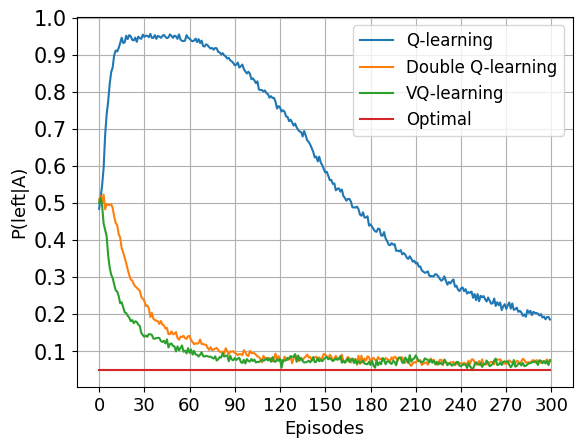

In [37]:
# a = prob_Q_A_left.mean(axis=0)
# b = prob_Q2_A_left.mean(axis=0)
# c = prob_AD_A_left.mean(axis=0)
# d = prob_E_A_left.mean(axis=0)
# e = prob_VQ_A_left.mean(axis=0)
plot_prob(prob_Q_A_left, prob_Q2_A_left, None, None, prob_VQ_A_left, std=False, note=note, save_path=save_path)
# plot_prob_A_left(prob_Q_A_left, None, None, None, None, std=False, note=note, save_path=save_path)
# plot_prob_A_left(prob_Q_A_left.mean(axis=0), prob_Q2_A_left.mean(axis=0), prob_AD_A_left.mean(axis=0), prob_E_A_left.mean(axis=0), prob_VQ_A_left.mean(axis=0))